In [1]:
#!pip install torchsummary

# Task 2

## Target

Implement the designed CNN architecture for CIFAR-10 dataset

## Result

- No. of Parameters     : 157,370
- Best Train Accuracy   : 88%
- Best Test Accuracy    : 70%

## Analysis

- The model was not able to generalize well (atthough it was not all that bad)
- The test accuracy was not changing much

# Importing the modules

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

from torch.utils.data.dataset import Subset, random_split
from torch.nn import functional as F
from torch import nn
from torch.optim.lr_scheduler import StepLR

import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm

## Data loading 

In [3]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [4]:
dataset_from_train = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True, 
                                        download=True, 
                                        transform=transform_train)
test_data  = torchvision.datasets.CIFAR10(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform_test)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
#len(dataset_from_train.data), len(test_data.data)

In [6]:
val_size = 8000
train_size = len(dataset_from_train.data) - val_size
train_data, val_data = random_split(dataset_from_train, [train_size, val_size])

In [7]:
# len(train_data.indices), len(val_data.indices), len(test_data.data)
# type(train_data.dataset), type(val_data.dataset)
# type(test_data)

In [8]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)
val_loader   = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=batch_size, num_workers=4, pin_memory=True)

In [9]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(images[1].shape)
print(labels[1].item())

torch.Size([128, 3, 32, 32])
torch.Size([3, 32, 32])
2


## Defining the CNN

In [10]:
class myNet(nn.Module):
    def __init__(self):
        super(myNet, self).__init__()
        
        # Block 1
        self.convblock1 = nn.Sequential(
                            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                            nn.ReLU()
                        ) 
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Block 2
        self.convblock2 = nn.Sequential(
                            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
                            nn.ReLU()
                        ) 
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Block 3
        self.convblock3 = nn.Sequential(
                            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
                            nn.ReLU()
                        ) 
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Block 4
        self.fc_layer = nn.Sequential(
                            nn.Linear(16*8*8, 128), 
                            nn.ReLU(),
                            nn.Linear(128, 10)
                        )
    def forward(self, x):
        
        # Conv Layers 
        x = self.convblock1(x)
        x = self.pool1(x)
        x = self.convblock2(x)
        x = self.pool2(x)
        x = self.convblock3(x)
           
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC Layer 
        x = self.fc_layer(x)
        x = x.view(-1, 10)
        
        return F.log_softmax(x, dim=-1)

# Model Params

In [11]:
# Shape of input image 
print(train_data.dataset.data[0].shape)

(32, 32, 3)


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = myNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]          18,464
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 16, 8, 8]           4,624
              ReLU-8             [-1, 16, 8, 8]               0
            Linear-9                  [-1, 128]         131,200
             ReLU-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 157,370
Trainable params: 157,370
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
F

# Training and Testing

In [13]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = criterion(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def val(model, criterion, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and Test our model

In [14]:
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=9, gamma=0.3)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, criterion, epoch)
#     scheduler.step()
    val(model, criterion, device, val_loader)

  0%|          | 0/329 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.643654227256775 Batch_id=328 Accuracy=35.90: 100%|██████████| 329/329 [00:06<00:00, 51.12it/s] 
  0%|          | 0/329 [00:00<?, ?it/s]


Validation set: Average loss: 0.0112, Accuracy: 3871/8000 (48.39%)

EPOCH: 2


Loss=1.030224084854126 Batch_id=328 Accuracy=53.06: 100%|██████████| 329/329 [00:06<00:00, 47.17it/s] 
  0%|          | 0/329 [00:00<?, ?it/s]


Validation set: Average loss: 0.0097, Accuracy: 4456/8000 (55.70%)

EPOCH: 3


Loss=1.0658202171325684 Batch_id=328 Accuracy=59.95: 100%|██████████| 329/329 [00:06<00:00, 51.34it/s]
  0%|          | 0/329 [00:00<?, ?it/s]


Validation set: Average loss: 0.0087, Accuracy: 4884/8000 (61.05%)

EPOCH: 4


Loss=0.8855127096176147 Batch_id=328 Accuracy=65.28: 100%|██████████| 329/329 [00:06<00:00, 51.72it/s]
  0%|          | 0/329 [00:00<?, ?it/s]


Validation set: Average loss: 0.0074, Accuracy: 5304/8000 (66.30%)

EPOCH: 5


Loss=0.7820216417312622 Batch_id=328 Accuracy=68.62: 100%|██████████| 329/329 [00:06<00:00, 52.16it/s]
  0%|          | 0/329 [00:00<?, ?it/s]


Validation set: Average loss: 0.0072, Accuracy: 5469/8000 (68.36%)

EPOCH: 6


Loss=0.3988737165927887 Batch_id=328 Accuracy=71.80: 100%|██████████| 329/329 [00:06<00:00, 51.21it/s]
  0%|          | 0/329 [00:00<?, ?it/s]


Validation set: Average loss: 0.0072, Accuracy: 5461/8000 (68.26%)

EPOCH: 7


Loss=0.6937777400016785 Batch_id=328 Accuracy=74.30: 100%|██████████| 329/329 [00:06<00:00, 51.63it/s]
  0%|          | 0/329 [00:00<?, ?it/s]


Validation set: Average loss: 0.0073, Accuracy: 5486/8000 (68.58%)

EPOCH: 8


Loss=1.321679949760437 Batch_id=328 Accuracy=76.66: 100%|██████████| 329/329 [00:06<00:00, 51.32it/s]  
  0%|          | 0/329 [00:00<?, ?it/s]


Validation set: Average loss: 0.0074, Accuracy: 5461/8000 (68.26%)

EPOCH: 9


Loss=0.8980584740638733 Batch_id=328 Accuracy=78.50: 100%|██████████| 329/329 [00:06<00:00, 51.33it/s] 
  0%|          | 0/329 [00:00<?, ?it/s]


Validation set: Average loss: 0.0067, Accuracy: 5687/8000 (71.09%)

EPOCH: 10


Loss=0.11241975426673889 Batch_id=328 Accuracy=80.26: 100%|██████████| 329/329 [00:06<00:00, 52.29it/s]
  0%|          | 0/329 [00:00<?, ?it/s]


Validation set: Average loss: 0.0072, Accuracy: 5661/8000 (70.76%)

EPOCH: 11


Loss=0.40133482217788696 Batch_id=328 Accuracy=82.68: 100%|██████████| 329/329 [00:06<00:00, 51.83it/s]
  0%|          | 0/329 [00:00<?, ?it/s]


Validation set: Average loss: 0.0081, Accuracy: 5454/8000 (68.17%)

EPOCH: 12


Loss=1.0643205642700195 Batch_id=328 Accuracy=84.39: 100%|██████████| 329/329 [00:06<00:00, 51.84it/s] 
  0%|          | 0/329 [00:00<?, ?it/s]


Validation set: Average loss: 0.0084, Accuracy: 5499/8000 (68.74%)

EPOCH: 13


Loss=0.5283166170120239 Batch_id=328 Accuracy=85.21: 100%|██████████| 329/329 [00:06<00:00, 51.75it/s] 
  0%|          | 0/329 [00:00<?, ?it/s]


Validation set: Average loss: 0.0081, Accuracy: 5623/8000 (70.29%)

EPOCH: 14


Loss=0.8843199610710144 Batch_id=328 Accuracy=87.13: 100%|██████████| 329/329 [00:06<00:00, 51.80it/s] 
  0%|          | 0/329 [00:00<?, ?it/s]


Validation set: Average loss: 0.0085, Accuracy: 5587/8000 (69.84%)

EPOCH: 15


Loss=0.24836862087249756 Batch_id=328 Accuracy=88.04: 100%|██████████| 329/329 [00:06<00:00, 51.66it/s]



Validation set: Average loss: 0.0089, Accuracy: 5626/8000 (70.33%)



Text(0.5, 1.0, 'Test Accuracy')

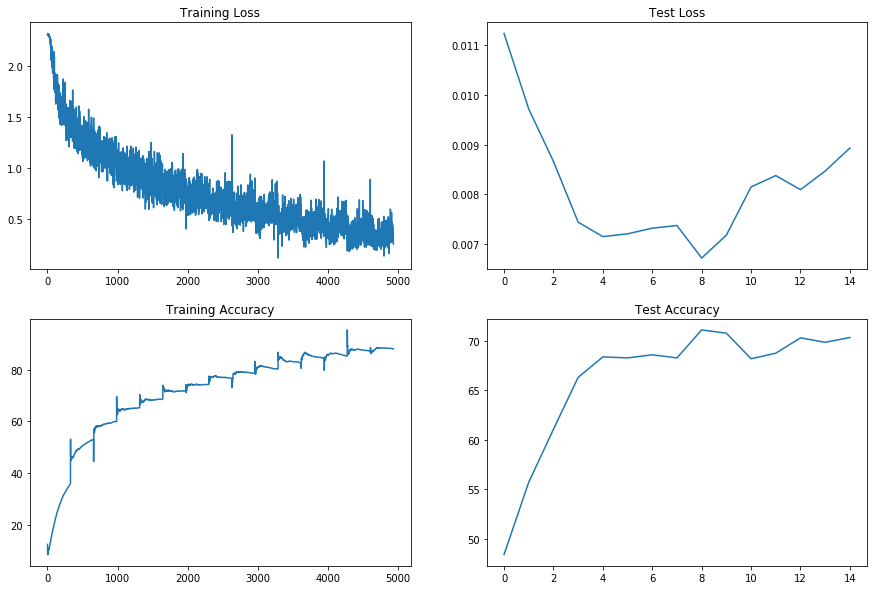

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")